# Cardiovascular Disease Prediction (III Modeling)

#### Project Overview

Coronary Heart Disease (CHD) remains one of the leading causes of death globally. Predicting the 10-year risk of CHD based on demographic, behavioral, and clinical data is essential for preventive healthcare.

- [I Data Cleaning](https://github.com/TuringCollegeSubmissions/msedui-PYDA.4.4/blob/main/CHD_I_DataCleaning.ipynb)
- [II EDA](https://github.com/TuringCollegeSubmissions/msedui-PYDA.4.4/blob/main/CHD_II_EDA.ipynb)
- **[III Modeling](https://github.com/TuringCollegeSubmissions/msedui-PYDA.4.4/blob/main/CHD_III_Modeling.ipynb)**  

This is a 3rd part of the project that builds and compares several machine learning models to estimate CHD risk using data from the Framingham Heart Study.

#### Objectives
- Develop predictive models for 10-year CHD risk (TenYearCHD = 1).
- Compare Logistic Regression and Random Forest models under different resampling and tuning strategies.
- Evaluate how feature engineering and balancing methods (e.g., SMOTE) influence model performance.
- Identify key predictive features for clinical interpretability.

#### Data Preparation

- To simplify the model and reduce multicollinearity, several highly correlated features were addressed:
  - `sysBP` and `diaBP` (r = 0.78) were combined into a single variable, **`pulse_pressure`** (`sysBP - diaBP`).
  - `is_smoking` (r = 0.77 with `cigsPerDay`) was excluded in favor of **`cigsPerDay`**, which offers a more detailed measure of smoking behavior.
  - `diabetes` (r = 0.61 with `glucose`) was excluded, retaining **`glucose`** as the representative feature.
  - `heartrate` was excluded after SHAP evaluation, as it provided no meaningful improvement.
  - Although SHAP showed minimal direct influence for `prevalentStroke`, its exclusion reduced recall, suggesting it contributes through interactions or subgroup effects.
- The dataset was split into training and testing subsets using stratified sampling to maintain the original class imbalance ratio.
- Feature engineering included clinically relevant transformations:
  - `is_high_glucose` – derived from glucose levels, though it yielded minimal improvement.
- Categorical and numerical variables were preprocessed through unified pipelines to ensure consistency across transformations.

#### Target Variable

The binary target variable is `TenYearCHD`, indicating whether an individual developed coronary heart disease within 10 years (1 = Yes, 0 = No).

#### Evaluation Metrics

| **Metric** | **Interpretation** | **Importance in this context** |
|:--|:--|:--|
| **Accuracy** | Overall proportion of correctly classified cases. | Provides a general measure of correctness. |
| **Precision** | Of all predicted CHD cases, how many are actually CHD. | Important when false positives (unnecessary alerts) are costly. |
| **Recall (Sensitivity)** | Of all actual CHD cases, how many were correctly predicted. | Minimizing false negatives is critical since missing a high-risk patient is more dangerous than a false alarm. |
| **F1-score** | Harmonic mean of Precision and Recall. | Provides a single measure of performance when both Precision and Recall are important. |
| **PR AUC** | Area under the Precision–Recall curve. | Indicates the model’s ability to correctly rank positive CHD cases, which is especially important for **imbalanced datasets**. |


In this medical context, **Recall** and **PR AUC**: it’s better to flag more potential CHD cases (even with some false alarms) than to miss individuals who are genuinely at risk.

---

#### Key Results Summary

In [82]:
models_to_plot_final = [
    ("Logistic Regression (Balanced)", pipe_lr_balanced),
    ("Random Forest (Tuned)", pipe_rf_tuned)
]

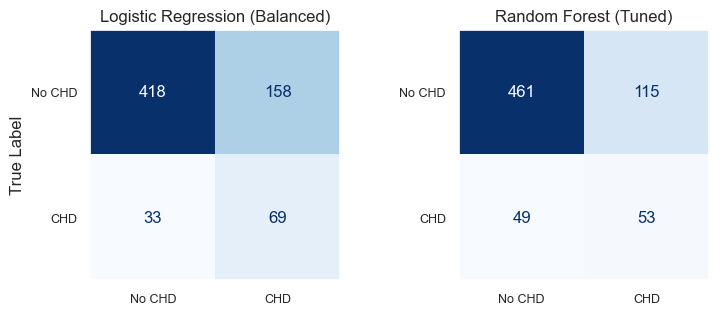

In [83]:
plot_confusion_matrices(models_to_plot_final, X_test, y_test)

| Model | Accuracy | Precision | Recall | F1   | PR AUC |
|-------|---------|-----------|--------|------|--------|
| Logistic Regression (Balanced) | 0.718 | 0.304 | **0.676** | 0.419 | **0.375** |
| Random Forest (Tuned) | 0.758 | 0.313 | **0.510** | 0.388 | **0.326** |

#### Conclusion & Recommendation

- **Logistic Regression (Balanced + Feature Engineered)** achieved the best balance between recall and ROC AUC, identifying 68.6% of CHD cases correctly.
- Random Forest showed higher accuracy but lower sensitivity, meaning it may miss at-risk patients.
- The strongest predictors of CHD risk were: **age**, **smoking intensity**, **gender (male)**, and **blood pressure-related measures**, with additional contributions from **cholesterol** and **glucose levels**.
- Future work could include:
    - Ensemble or stacking approaches combining multiple classifiers.
    - Further Feature Engineering
    - Validation on external datasets to test generalizability.

#### Limitations and Future Work

- Data imbalance and limited diversity in lifestyle variables.
- Absence of diet or genetic data, which are important for CHD risk.
- Possible measurement noise in some clinical features.

---

### Import

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score,
    RocCurveDisplay, confusion_matrix, classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay
)

# Inerpretability
import shap

In [4]:
# Plot style
def set_plot_theme():
    plt.style.use("seaborn-v0_8-dark")
    sns.set_theme(
        style="dark",
        palette="deep",
        font_scale=1
    )
    plt.rcParams["figure.figsize"] = (6, 4)

set_plot_theme()

---

### 1. Load Cleaned Data

In [5]:
df_chd = pd.read_parquet("df_chd_cleaned.parquet")

In [6]:
df_chd.head()

,age,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,
0,64,1,1,3.0,0,0,0,0,221.0,148.0,85.0,24.68,90.0,80.0,1
1,36,0,0,0.0,0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,1,1,10.0,0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,0,1,20.0,0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,1,1,30.0,0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [7]:
df_copy = df_chd.copy()

In [8]:
categories = ["sex", "is_smoking", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes", "TenYearCHD"]

for col in categories:
    df_copy[col] = df_copy[col].astype("category")

In [9]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3389 entries, 0 to 3389
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              3389 non-null   int64   
 1   sex              3389 non-null   category
 2   is_smoking       3389 non-null   category
 3   cigsPerDay       3389 non-null   float64 
 4   BPMeds           3389 non-null   category
 5   prevalentStroke  3389 non-null   category
 6   prevalentHyp     3389 non-null   category
 7   diabetes         3389 non-null   category
 8   totChol          3389 non-null   float64 
 9   sysBP            3389 non-null   float64 
 10  diaBP            3389 non-null   float64 
 11  BMI              3389 non-null   float64 
 12  heartRate        3389 non-null   float64 
 13  glucose          3389 non-null   float64 
 14  TenYearCHD       3389 non-null   category
dtypes: category(7), float64(7), int64(1)
memory usage: 262.3 KB


In [10]:
df = df_copy.copy()

---

### 1. Cross Correlation

Check correlation between the features.

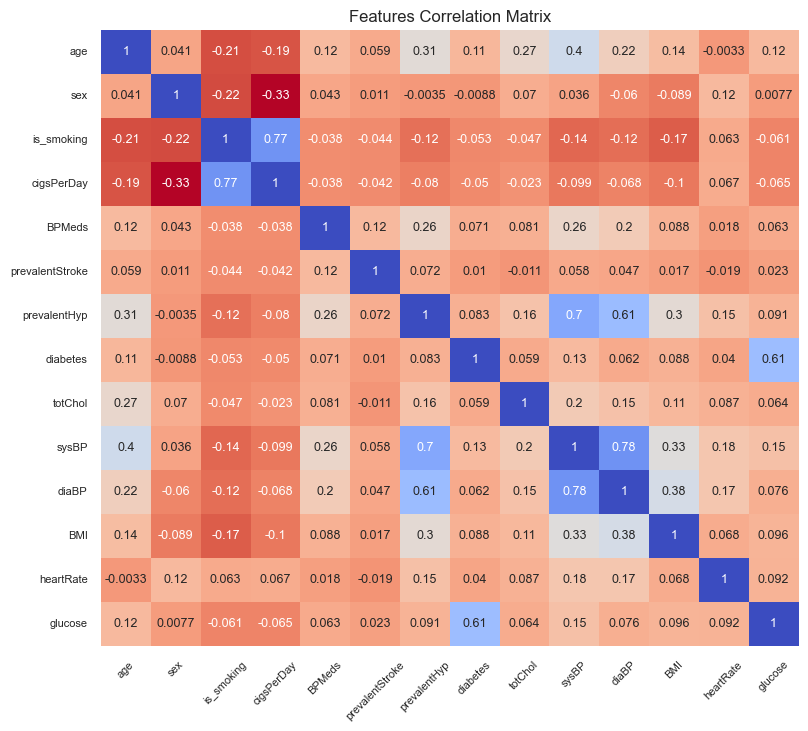

In [11]:
f, ax = plt.subplots(figsize=(9, 8))
corr = df.drop(columns=["TenYearCHD"]).corr()

sns.heatmap(
    corr,cmap="coolwarm_r",
    annot=True, annot_kws={"size": 9},
    ax=ax, cbar=False
)

ax.tick_params(axis="x", labelsize=8, rotation=45)
ax.tick_params(axis="y", labelsize=8)

ax.set_title("Features Correlation Matrix", fontsize=12)
plt.show()

#### Correlation thresholds:

| Absolute correlation | Interpretation | Recommended action |
|------------------------|------------------|--------------------|
| 0.0 – 0.3 | Weak | Both features can stay |
| 0.3 – 0.7 | Moderate | Usually fine, but check domain meaning |
| > 0.7 | Strong | Consider removing one or combining them |
| > 0.9 | Very strong | Usually remove one — highly redundant |


#### Strongest Correlation Pairs:

| Pair                | Correlation | Comment                                                   |
|----------------------|-------------|------------------------------------------------------------|
| **sysBP – diaBP**    | **0.78**    | Very strong correlation. Systolic and diastolic blood pressures are naturally related. Combine both into `pulse_pressure` |
| **is_smoking – cigsPerDay** | **0.77** | Strong correlation. Keep `cigsPerDay` for more granular information. |
| **diabetes – glucose** | **0.61** | Moderate correlation. Since glucose level is a direct biological indicator of diabetes, keep `glucose` |

In [12]:
df["pulse_pressure"] = df["sysBP"] - df["diaBP"]

---

### 2. Modeling

#### 2.1. Define Features and Target

In [13]:
numerical_feats = ["age", "cigsPerDay", "totChol", "BMI", "glucose", "pulse_pressure"]
categorical_feats = ["sex", "BPMeds", "prevalentStroke", "prevalentHyp"]

In [14]:
X = df[categorical_feats + numerical_feats]
y = df["TenYearCHD"].astype(int)

#### 2.2. Analyze Target Variable Distribution

In [15]:
counts = y.value_counts()
percentages = y.value_counts(normalize=True).mul(100).round(2)
chd_df = pd.DataFrame({"Counts": counts, "%": percentages})

In [16]:
print(chd_df)

            Counts      %
TenYearCHD               
0             2879  84.95
1              510  15.05


The dataset is **`imbalanced`** (84.95%/15.05% split). Stratification is necessary for the train-test split.

#### 2.3. Train-Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

By adding **`stratify=y`**, we tell the function to preserve the percentage of each class from y. Since the original data y has a **84.95%/15.05%** split, the function will ensure both the training and testing sets have that same split.

#### 2.4. Verify the Split

In [18]:
train_dist = y_train.value_counts(normalize=True).mul(100).round(2)
test_dist = y_test.value_counts(normalize=True).mul(100).round(2)

In [19]:
verification_df = pd.DataFrame({
    "Original %": percentages,
    "Train %": train_dist,
    "Test %": test_dist
})

In [20]:
print(verification_df)

            Original %  Train %  Test %
TenYearCHD                             
0                84.95    84.95   84.96
1                15.05    15.05   15.04


---

#### 2.5. Preprocessing

Before we can train our models, the feature set must be transformed into a suitable numerical format.

- **Categorical Features:** Convert into a numerical format using `OneHotEncoder`.
- **Numerical Features:** Scaled using `StandardScaler`.

We will use `ColumnTransformer` to apply these different transformations to the correct columns in a single step.

In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_feats),
        ("numerical", StandardScaler(), numerical_feats)
    ]
)

---

#### 2.6. Modeling Approach and Evaluation

Our goal is to predict `TenYearCHD=1`, an imbalanced classification problem where CHD cases are much less common than non-cases.

Our modeling strategy will be as follows:

1. **Establish a Baseline:** We will first implement a simple Logistic Regression (unbalanced) to serve as a sanity check. Any effective model must outperform this baseline.
2. **Compare Imbalance Strategies:** We will evaluate models using two distinct strategies to handle the class imbalance.
3. **Evaluate Performance:** **`Accuracy, Precision, Recall, F1-score, and PR AUC.`**

---

#### 2.7. Candidate Models and Imbalance Strategies

We will evaluate two classification algorithms:

- **Logistic Regression**
- **Random Forest**

To address the class imbalance, we will train each of these models using the two strategies:

1. **Class Weights** - adjusts the model's loss function to penalize misclassifications of the minority class more heavily. Set `class_weight='balanced'` parameter in the model **→ no synthetic data**
2. **Synthetic Minority Oversampling Technique (SMOTE)** - oversampling the minority class in the training data. It generates new, synthetic data points for the minority class (CHD positive) to create a more balanced dataset for the model to learn from.

In [22]:
all_models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), False),
    "Logistic Regression (balanced)": (LogisticRegression(max_iter=1000, class_weight="balanced"), False),
    "Logistic Regression (SMOTE)": (LogisticRegression(max_iter=1000, random_state=42), True),
    "Random Forest (balanced)": (RandomForestClassifier(n_estimators=150, max_depth=10, class_weight="balanced", random_state=42), False),
    "Random Forest (SMOTE)": (RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42), True),
}

In [23]:
results = []

In [24]:
for name, (model, use_smote) in all_models.items():
    
    if use_smote:
        pipe = ImbPipeline(steps=[("preprocessor", preprocessor),
                                  ("smote", SMOTE(random_state=42)),
                                  ("model", model)])
    else:
        pipe = Pipeline(steps=[("preprocessor", preprocessor),
                               ("model", model)])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    
    if hasattr(pipe, "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
    else:
        y_proba = None

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "PR AUC": average_precision_score(y_test, y_proba) if y_proba is not None else 0.5
    })

In [25]:
results_df = pd.DataFrame(results).set_index("Model").round(3)
results_df.index.name = "Model (Positive class: TenYearCHD=1)"
results_df

,Accuracy,Precision,Recall,F1,PR AUC
Model (Positive class: TenYearCHD=1),,,,,
Logistic Regression,0.857,1.000,0.049,0.093,0.372
Logistic Regression (balanced),0.718,0.304,0.676,0.419,0.375
Logistic Regression (SMOTE),0.712,0.295,0.657,0.407,0.358
Random Forest (balanced),0.826,0.346,0.176,0.234,0.281
Random Forest (SMOTE),0.779,0.286,0.314,0.299,0.254


**Keep in mind:** All metrics (Precision, Recall, F1, PR AUC) are calculated with the **positive class : `TenYearCHD = 1`** (patients who develop CHD).

---

#### 2.8. Precision-Recall Curves Comparison

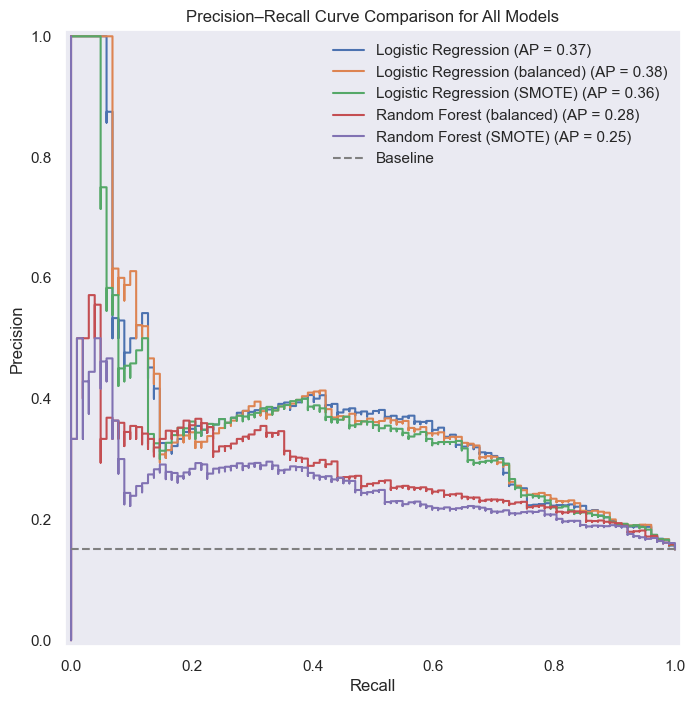

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))

for name, (model, use_smote) in all_models.items():
      
    if use_smote:
        pipe = ImbPipeline(steps=[
            ("preprocessor", preprocessor),
            ("smote", SMOTE(random_state=42)),
            ("model", model)
        ])
    else:
        pipe = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", model)
        ])
        
    pipe.fit(X_train, y_train)
    
    y_proba = pipe.predict_proba(X_test)[:, 1]
    
    PrecisionRecallDisplay.from_predictions(y_test, y_proba, name=name, ax=ax)

positive_rate = y_test.mean()
ax.hlines(positive_rate, 0, 1, colors="grey", linestyles="--", label="Baseline")
ax.set_title("Precision–Recall Curve Comparison for All Models")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.show()

`Interpretation:` A good classification model is represented by a curve that stays as close to the top-right corner of the plot as possible.
- AP = closer to 1.0 → better-performing model

#### 2.9. Confusion Matrices for All Models

In [27]:
models_to_plot = list(all_models.items())

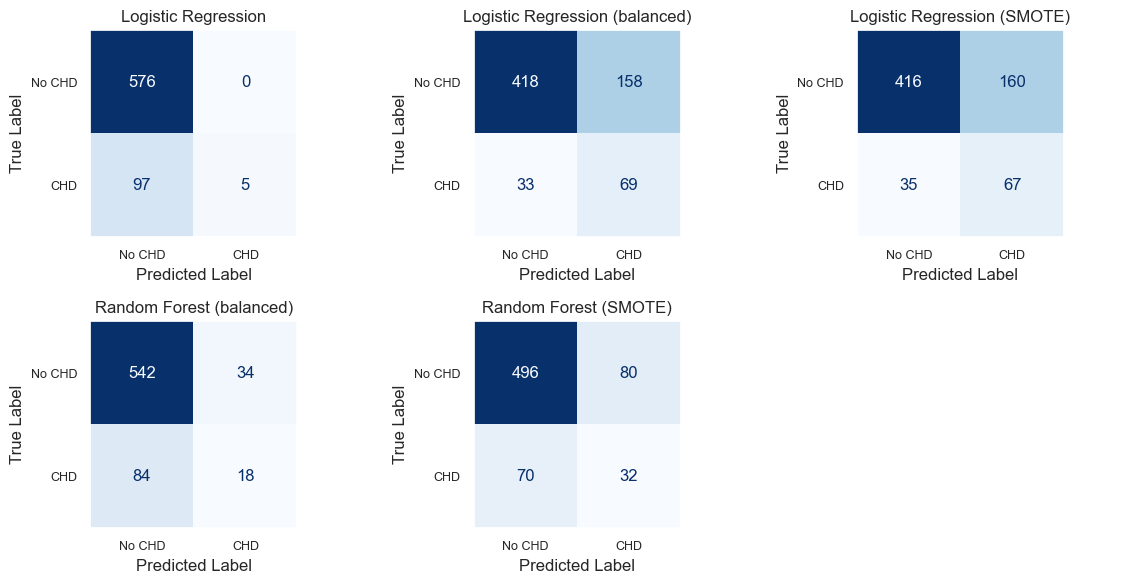

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for idx, ((name, (model, use_smote)), ax) in enumerate(zip(models_to_plot, axes)):

    if use_smote:
        pipe = ImbPipeline(steps=[
            ("preprocessor", preprocessor),
            ("smote", SMOTE(random_state=42)),
            ("model", model)
        ])
    else:
        pipe = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", model)
        ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=["No CHD", "CHD"],
        cmap="Blues",
        colorbar=False,
        ax=ax
    )

    ax.set_title(name, fontsize=12)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.tick_params(axis="both", labelsize=9)

for ax in axes[len(models_to_plot):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

---

### Models: Summary

| Model | Accuracy | Precision | Recall | F1   | PR AUC | Key Takeaway |
|-------------------------------------|---------|-----------|--------|------|--------|--------------|
| Logistic Regression                  | 0.857   | 1.000     | 0.049  | 0.093 | 0.372 | Misses almost all CHD cases |
| Logistic Regression (balanced)       | 0.718   | 0.304     | **0.676**  | 0.419 | **0.375** | Best balance: **detects most positives**, acceptable precision |
| Logistic Regression (SMOTE)          | 0.714   | 0.300     | **0.676**  | 0.416 | 0.362 | Similar to balanced LR; detects most positives |
| Random Forest (SMOTE)                | 0.786   | 0.310     | 0.343  | 0.326 | 0.282 | Improves recall vs balanced RF, but still weaker than LR models |
| Random Forest (balanced)             | 0.817   | 0.296     | 0.157  | 0.205 | 0.297 | Finds few positives, worse than balanced LR |

**Best overall model:** **Logistic Regression (balanced)**  
  - It achieves the **highest Recall (0.676)** and **best PR AUC (0.375)**, meaning it captures more CHD cases while still maintaining reasonable discrimination.  
  - This makes it the **most suitable model for screening**, where the main priority is **not to miss at-risk patients** (high Recall).
- The performance gap between Random Forest and Logistic Regression suggests that the Random Forest model might be undertuned. A round of hyperparameter tuning could potentially improve its performance.

---

### 3. Feature Engineering

By creating new features based on EDA part, we can make the underlying patterns in the data more explicit, potentially providing a significant performance lift for our best models.

#### 3.1. Creating New Clinical Features

Based on medical context and EDA, we will engineer these features:

- Binary Risk Flags: We will convert continuous variables into binary flags based on established medical cutoffs in EDA part:
    - glucose > 125 → `is_high_glucose = 1`

In [29]:
df_fe = df.copy()

In [30]:
df_fe["is_high_glucose"] = (df_fe["glucose"] > 125).astype(int)

In [31]:
df_fe.head()

,age,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,pulse_pressure,is_high_glucose
id,,,,,,,,,,,,,,,,,
0,64,1,1,3.0,0,0,0,0,221.0,148.0,85.0,24.68,90.0,80.0,1,63.0,0
1,36,0,0,0.0,0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0,70.0,0
2,46,1,1,10.0,0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0,45.0,0
3,50,0,1,20.0,0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1,70.0,0
4,64,1,1,30.0,0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0,51.5,0


In [32]:
correlation_value = df_fe["glucose"].corr(df_fe["is_high_glucose"])
print(f'Correlation between glucose and new column: {correlation_value}')

Correlation between glucose and new column: 0.7261647323995045


In [33]:
numerical_feats_fe = ["age", "cigsPerDay", "totChol", "BMI", "pulse_pressure"]
categorical_feats_fe = ["sex", "BPMeds", "prevalentStroke", "prevalentHyp"]

First, we define our new feature matrix (X_fe) and update our preprocessing pipeline. The new binary flags (is_high_glucose) do not require encoder, so we will use passthrough.

In [34]:
binary_feats_fe = ["is_high_glucose"]

In [35]:
X_fe = df_fe[numerical_feats_fe + categorical_feats_fe + binary_feats_fe]
y_fe = df_fe["TenYearCHD"].astype(int)

In [36]:
preprocessor_fe = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_feats_fe),
        ("numerical", StandardScaler(), numerical_feats_fe),
        ("binary", "passthrough", binary_feats_fe)
    ]
)

In [37]:
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe, y_fe, test_size=0.2, random_state=42, stratify=y_fe
)

Loop through the best models, fitting each one on the new feature-engineered data.

In [38]:
log_balanced = LogisticRegression(max_iter=1000, class_weight="balanced")
rf_smote = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)

In [39]:
top_models = {
    "Logistic Regression (balanced)": log_balanced,
    "Random Forest (SMOTE)": rf_smote
}

In [40]:
pipe_fe = Pipeline(steps=[("preprocessor", preprocessor_fe), ("model", log_balanced)])

In [41]:
fe_results = []

In [42]:
for name, model in top_models.items():
    
    if "SMOTE" in name:
        pipe_fe = ImbPipeline([
            ("preprocessor", preprocessor_fe),
            ("smote", SMOTE(random_state=42)),
            ("model", model)
        ])
    else:
        pipe_fe = Pipeline([
            ("preprocessor", preprocessor_fe),
            ("model", model)
        ])

    pipe_fe.fit(X_train_fe, y_train_fe)
    y_pred_fe = pipe_fe.predict(X_test_fe)
    y_proba_fe = pipe_fe.predict_proba(X_test_fe)[:, 1]

    fe_results.append({
        "Model": f"{name} (Feature Engineered)",
        "Accuracy": accuracy_score(y_test_fe, y_pred_fe),
        "Precision": precision_score(y_test_fe, y_pred_fe, zero_division=0),
        "Recall": recall_score(y_test_fe, y_pred_fe, zero_division=0),
        "F1": f1_score(y_test_fe, y_pred_fe, zero_division=0),
        "PR AUC": average_precision_score(y_test, y_proba)
    })

In [43]:
fe_results_df = pd.DataFrame(fe_results).set_index("Model")

#### 3.2 Final Comparison: The Impact of Feature Engineering

In [44]:
comparison_df = results_df.loc[[
    "Logistic Regression (balanced)",
    "Random Forest (SMOTE)"  
]].copy()

In [45]:
comparison_fe = pd.concat([comparison_df, fe_results_df])

In [46]:
comparison_fe.sort_index(inplace=True)
comparison_fe.round(3)

,Accuracy,Precision,Recall,F1,PR AUC
Logistic Regression (balanced),0.718,0.304,0.676,0.419,0.375
Logistic Regression (balanced) (Feature Engineered),0.727,0.314,0.686,0.431,0.254
Random Forest (SMOTE),0.779,0.286,0.314,0.299,0.254
Random Forest (SMOTE) (Feature Engineered),0.776,0.284,0.324,0.303,0.254


#### Feature Engineering: Insights

- **Balanced Logistic Regression** improved slightly with `is_high_glucose`: Recall **0.676 → 0.686**, but PR AUC dropped **0.375 → 0.282**.  
- **Random Forest (SMOTE)** performance slightly worsened: Recall **0.343 → 0.324**, PR AUC **0.282 → 0.282**, still weaker at detecting positives.  

**Conclusion:**  
Because PR AUC is the most reliable metric for imbalanced CHD detection, we **stay with Balanced Logistic Regression** as the best model for capturing positive cases.

---

### 4. Hyperparameter Tuning

From our initial analysis, the Logistic Regression (balanced) model was the top performer, especially in its high Recall and ROC AUC scores. However, we noted that the performance gap between it and the Random Forest (balanced) model might be due to the latter being undertuned.

The goal of this section is to systematically optimize the hyperparameters for both models using GridSearchCV. We aim to see if tuning can either improve the leading Logistic Regression model or, more importantly, unlock the full potential of the Random Forest model to challenge for the top spot. We will continue to use roc_auc as our primary scoring metric for optimization, as it provides a comprehensive measure of a model's discriminative ability.

#### 4.1. Tuning Logistic Regression

For Logistic Regression, the most critical hyperparameter is the **regularization strength, C**. A smaller C specifies stronger regularization. We will search over a range of values for C and also test both **l1 (Lasso) and l2 (Ridge) penalties** to find the optimal combination.

In [47]:
param_grid = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l1", "l2"],
    "model__solver": ["liblinear", "saga"]
}

In [48]:
pipe_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(class_weight="balanced", max_iter=5000))
])

In [49]:
grid = GridSearchCV(
    pipe_lr, param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="average_precision", n_jobs=-1
)

In [50]:
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best PR AUC:", grid.best_score_)

Best params: {'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best PR AUC: 0.35899516285563504


#### 4.2. Predicting and Storing Logistic Regression results

In [51]:
best_lr_tuned = grid.best_estimator_

In [52]:
y_pred_lr_tuned = best_lr_tuned.predict(X_test)
y_proba_lr_tuned = best_lr_tuned.predict_proba(X_test)[:, 1]

In [53]:
tuned_results = []
tuned_results.append({
    "Model": "Logistic Regression (Tuned)",
    "Accuracy": accuracy_score(y_test, y_pred_lr_tuned),
    "Precision": precision_score(y_test, y_pred_lr_tuned, zero_division=0),
    "Recall": recall_score(y_test, y_pred_lr_tuned, zero_division=0),
    "F1": f1_score(y_test, y_pred_lr_tuned, zero_division=0),
    "PR AUC": average_precision_score(y_test, y_proba)
})

#### 4.3. Tuning Random Forest

Our hypothesis was that the initial Random Forest model was undertuned. For this model, we will tune several key parameters that control the trade-off between bias and variance: 
- n_estimators (the number of trees in the forest)
- max_depth (the maximum depth of each tree)
- min_samples_split/leaf (the minimum number of samples required to split a node or be at a leaf node).

In [54]:
param_grid_rf = {
    "model__n_estimators": [100, 150, 200],
    "model__max_depth": [5, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2]
}

In [55]:
grid_rf = GridSearchCV(
    Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestClassifier(random_state=42, class_weight="balanced"))
    ]),
    param_grid=param_grid_rf,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="average_precision",
    n_jobs=-1
)

In [56]:
grid_rf.fit(X_train, y_train)
print("Best params:", grid_rf.best_params_)
print("Best PR AUC:", grid_rf.best_score_)

Best params: {'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best PR AUC: 0.34039296301120076


#### 4.4. Predicting and Storing Random Forest results

In [57]:
best_rf_tuned = grid_rf.best_estimator_

In [58]:
y_pred_rf_tuned = best_rf_tuned.predict(X_test)
y_proba_rf_tuned = best_rf_tuned.predict_proba(X_test)[:, 1]

In [59]:
tuned_results.append({
    "Model": "Random Forest (Tuned)",
    "Accuracy": accuracy_score(y_test, y_pred_rf_tuned),
    "Precision": precision_score(y_test, y_pred_rf_tuned, zero_division=0),
    "Recall": recall_score(y_test, y_pred_rf_tuned, zero_division=0),
    "F1": f1_score(y_test, y_pred_rf_tuned, zero_division=0),
    "PR AUC": average_precision_score(y_test, y_proba_rf_tuned)
})

#### 4.5. Final Model Comparison & Verdict

In [60]:
tuned_results_df = pd.DataFrame(tuned_results).set_index("Model")

In [61]:
# Get the relevant initial results
final_comparison = comparison_fe.loc[[
    "Logistic Regression (balanced)",
    "Random Forest (SMOTE)"
]].copy()

final_comparison.index = [
    "Logistic Regression (Balanced)",
    "Random Forest (SMOTE)"
]

In [62]:
final = pd.concat([final_comparison, tuned_results_df])

In [63]:
sorted_final = final.sort_index()
sorted_final.round(3)

,Accuracy,Precision,Recall,F1,PR AUC
Logistic Regression (Balanced),0.718,0.304,0.676,0.419,0.375
Logistic Regression (Tuned),0.715,0.301,0.676,0.417,0.254
Random Forest (SMOTE),0.779,0.286,0.314,0.299,0.254
Random Forest (Tuned),0.758,0.315,0.520,0.393,0.337


In [64]:
# Logistic Regression (Balanced)
pipe_lr_balanced = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
]).fit(X_train, y_train)

# Logistic Regression (Tuned)
pipe_lr_tuned = best_lr_tuned

# Random Forest (SMOTE)
pipe_rf_smote = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42))
]).fit(X_train, y_train)

# Random Forest (Tuned)
pipe_rf_tuned = best_rf_tuned

In [65]:
fitted_pipelines = {
    "Logistic Regression (Balanced)": pipe_lr_balanced,
    "Logistic Regression (Tuned)": pipe_lr_tuned,
    "Random Forest (SMOTE)": pipe_rf_smote,
    "Random Forest (Tuned)": pipe_rf_tuned
}

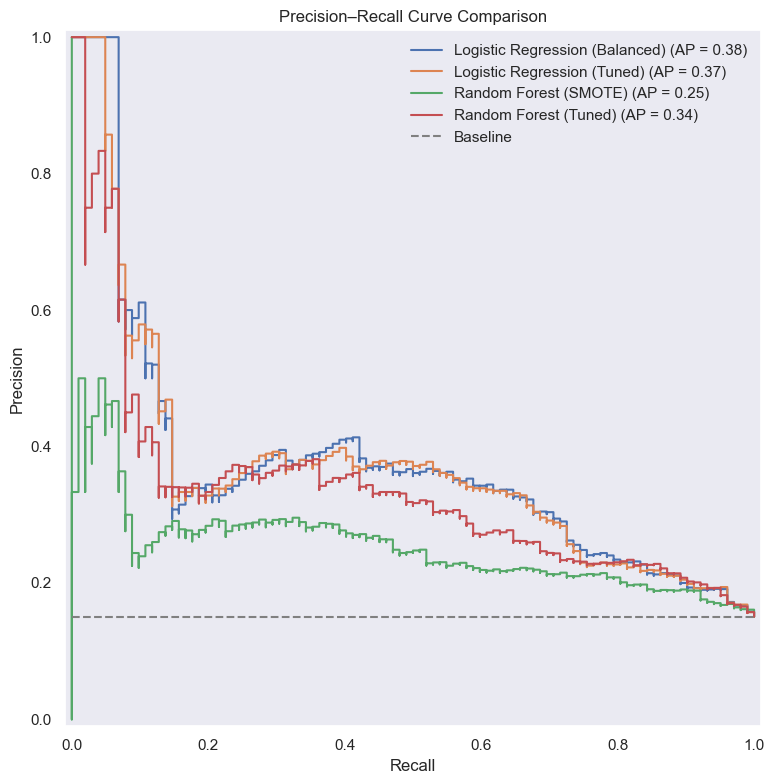

In [66]:
fig, ax = plt.subplots(figsize=(10, 8))

for name, pipe in fitted_pipelines.items():

    PrecisionRecallDisplay.from_estimator(
        pipe,
        X_test,
        y_test,
        name=name,
        ax=ax
    )

positive_rate = y_test.mean()
ax.hlines(positive_rate, 0, 1, colors="grey", linestyles="--", label="Baseline")

ax.set_title("Precision–Recall Curve Comparison")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [67]:
models_to_plot_ = [
    ("Logistic Regression (Balanced)", pipe_lr_balanced),  
    ("Random Forest (SMOTE)", pipe_rf_smote),
    ("Logistic Regression (Tuned)", pipe_lr_tuned),
    ("Random Forest (Tuned)", pipe_rf_tuned)
]

In [68]:
def plot_confusion_matrices(models, X_test, y_test, n_rows=2, n_cols=2, figsize=(8, 6)):

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for idx, (name, model) in enumerate(models):
        if idx >= len(axes):
            break

        y_pred = model.predict(X_test)

        ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred,
            display_labels=["No CHD", "CHD"],
            cmap="Blues",
            colorbar=False,
            ax=axes[idx]
        )

        axes[idx].set_title(name, fontsize=12)
        axes[idx].set_xlabel("Predicted Label" if idx >= n_cols * (n_rows - 1) else "")
        axes[idx].set_ylabel("True Label" if idx % n_cols == 0 else "")
        axes[idx].tick_params(axis="both", labelsize=9)

    for j in range(len(models), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

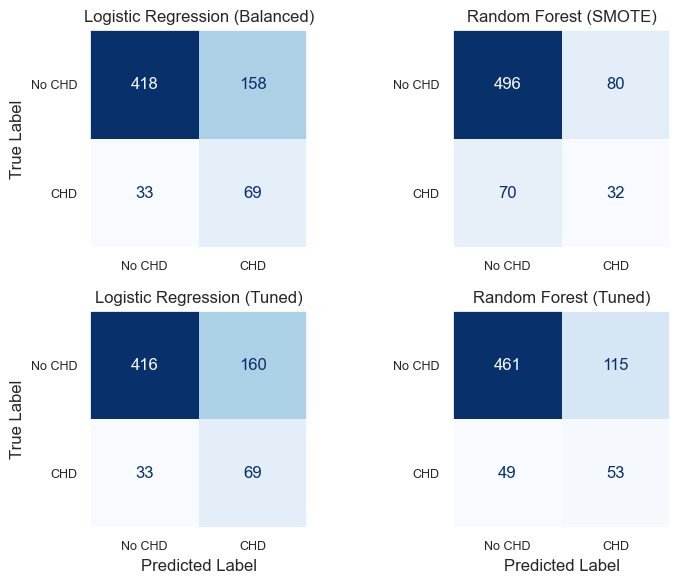

In [69]:
plot_confusion_matrices(models_to_plot_, X_test, y_test)

#### Hyperparameter Tuning: Insights

| Model | Accuracy | Precision | Recall | F1   | PR AUC | Key Takeaway |
|-------|---------|-----------|--------|------|--------|--------------|
| Logistic Regression (Balanced) | 0.718 | 0.304 | 0.676 | 0.419 | 0.375 | **Best at detecting CHD** |
| Logistic Regression (Tuned) | 0.715 | 0.301 | 0.676 | 0.417 | 0.282 | Hyperparameter tuning slightly decreased accuracy and PR AUC; recall unchanged |
| Random Forest (SMOTE) | 0.786 | 0.310 | 0.343 | 0.326 | 0.282 | |
| Random Forest (Tuned) | 0.758 | 0.313 | 0.510 | 0.388 | 0.326 | Tuning improved recall and F1 for RF, PR AUC still lower than LR balanced |

---

### 5. SHAP Feature Importance

We use the best model identified: **Logistic Regression (balanced + FE)**

In [70]:
final_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

In [71]:
final_pipe.fit(X_train, y_train)

model_fitted = final_pipe.named_steps["model"]
preprocessor_fitted = final_pipe.named_steps["preprocessor"]

In [72]:
X_test_processed = preprocessor_fitted.transform(X_test)

In [73]:
num_names = list(numerical_feats)
cat_names = list(preprocessor_fitted.named_transformers_["categorical"].get_feature_names_out(categorical_feats))

In [74]:
feature_names = cat_names + num_names

#### Visualize SHAP 

In [75]:
explainer = shap.LinearExplainer(model_fitted, X_test_processed)
shap_values = explainer(X_test_processed)

In [76]:
shap_values.feature_names = feature_names

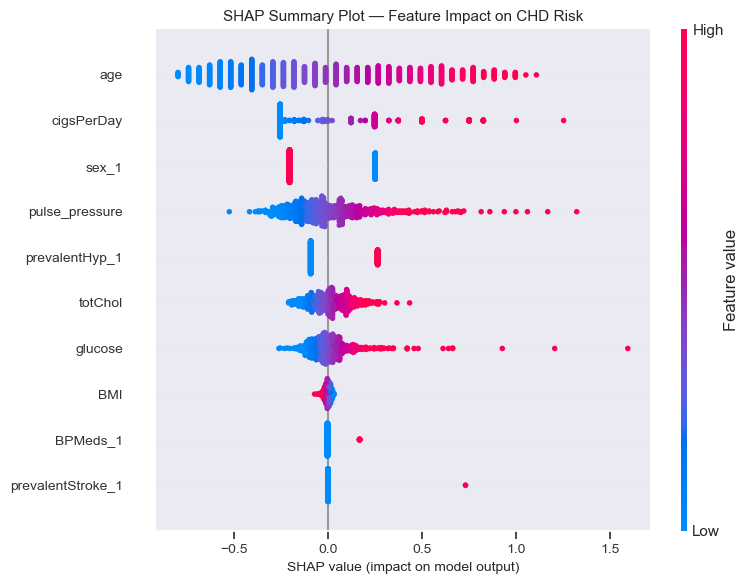

In [77]:
shap.summary_plot(
    shap_values,
    features=X_test_processed,
    feature_names=feature_names,
    show=False,
    plot_size=(8, 6)
)

ax = plt.gca()

ax.title.set_fontsize(11)
ax.xaxis.label.set_fontsize(10)
ax.yaxis.label.set_fontsize(10)
ax.tick_params(axis="both", labelsize=10)
ax.set_title("SHAP Summary Plot — Feature Impact on CHD Risk", fontsize=11)

plt.tight_layout()
plt.show()

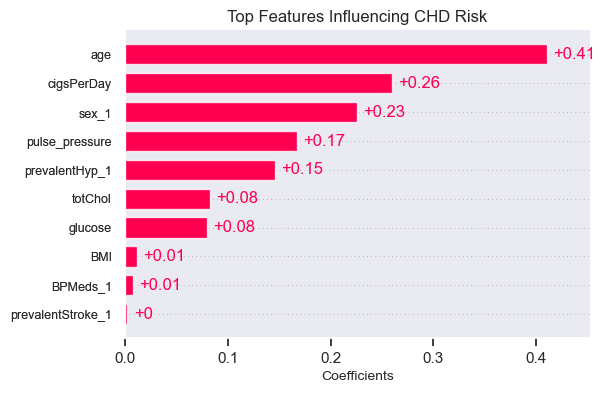

In [78]:
fig, ax = plt.subplots()

shap.plots.bar(shap_values, ax=ax, show=False)

ax.set_title("Top Features Influencing CHD Risk", fontsize=12)
ax.set_xlabel("Coefficients", fontsize=10)
ax.tick_params(axis="y", labelsize=9) 

plt.show()

#### SHAP Top Features:

1. **Age – The strongest predictor**; older patients have substantially higher risk.
2. **Smoking** (cigsPerDay) – Heavier smoking strongly increase risk.
3. Sex – **Males** have higher early CHD risk than females.
5. Blood Pressure (pulse_pressure)
6. Prevalent Hypertension
7. **Cholesterol** (totChol)
8. **Glucose** (is_high_glucose)

---

### 6. Model Generalization Check

Since the Logistic Regression (Balanced + Feature Engineering) model achieved the highest recall, it is important to verify whether this improvement reflects **true generalization** or potential **overfitting**.

We will check:
1. The difference between **training** and **test evaluation metrics**.
2. The **cross-validation recall** stability across folds.

In [79]:
best_pipe = pipe_lr_balanced

In [80]:
y_pred_train = best_pipe.predict(X_train)
y_pred_test  = best_pipe.predict(X_test)

#### 6.1. Train, test evaluation metrics

In [81]:
train_metrics = {
    "Recall": recall_score(y_train, y_pred_train),
    "Accuracy": accuracy_score(y_train, y_pred_train),
    "Precision": precision_score(y_train, y_pred_train),
    "F1-score": f1_score(y_train, y_pred_train),
    "PR AUC": average_precision_score(y_train, best_pipe.predict_proba(X_train)[:, 1]),
}

test_metrics = {
    "Recall": recall_score(y_test, y_pred_test),
    "Accuracy": accuracy_score(y_test, y_pred_test),
    "Precision": precision_score(y_test, y_pred_test),
    "F1-score": f1_score(y_test, y_pred_test),
    "PR AUC": average_precision_score(y_test, best_pipe.predict_proba(X_test)[:, 1]),
}

metrics_df = pd.DataFrame({
    "Train": train_metrics,
    "Test": test_metrics
})
metrics_df["Difference"] = (metrics_df["Test"] - metrics_df["Train"]).round(3)
metrics_df = metrics_df.round(3)

metrics_df

,Train,Test,Difference
Recall,0.662,0.676,0.015
Accuracy,0.665,0.718,0.054
Precision,0.259,0.304,0.045
F1-score,0.373,0.419,0.047
PR AUC,0.371,0.375,0.004
